# HW1: Mobile Robot Kinematics & Control

### EECE 5550: Mobile Robotics (Spring 2025)


**Collaboration Statement:**

Myself Alay Shah, I have collaborated with Pradeep Surya Dadi in understanding the theory of pure pursuit algorithm and also discussed some methods for better control.
I have discussed with Atharva and Akshaj Raut about approach for solving pure pursuit and finding angle to goal and omega.

# Installation

This semester, we will use a custom simulator, called `gym-neu-racing`, to develop navigation algorithms. We implemented the basic structure of this simulator for you, and the HW assignments will ask you to implement important functions (e.g., kinematics, sensing, planning, mapping).

To install the simulator, you can use this command (it will download the latest code from GitLab and automatically install it in the environment your Colab notebook runs in):

In [2]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to /tmp/pip-req-build-fk552nk9
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git /tmp/pip-req-build-fk552nk9
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit 60f6a0e80b5ae6dd14fb13a837c252d0d88fe571
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 27.1 MB/s eta 0:00:00
  Created wheel for gym_neu_racing: filename=gym_neu_racing-0.0.1-py3-none-any.whl size=65573 sha256=6022a00f77320dd8225e0f665689bacd346e0e70358a54cb9eaf91f0ba155928
  Stored in directory: /tmp/pip-ephem-wheel-cache-64jgoi3e/wheels/4f/e1/e1/050619ec6014120d47555de901a265d190efdd96f993c95344
Successfully built gym_neu_racing


Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [3]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable

You can create an instance of the simulator that you'll build on throughout the assignment:

In [4]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

# Problem 1

## 1a) Run the baseline simulator & generate a plot

Here's an example of how to run the simulator for a few timesteps. In this assignment, we told the simulator to return the true state of the environment (in future assignments, we'll only give noisy sensor data).

In this problem, you should make a plot of the system's state over time. This will be helpful as you debug future parts of the assignment. This part uses the Unicycle kinematic model that's built into the simulator.

**Deliverables**:
- Implement the `plot_path` method. At a minimum, you should plot the (x,y) position over time (the first 2 elements of the state vector). You are welcome to add other capabilities to your `plot_path` function as you go through the assignment (e.g., visualizing the heading angle and/or the goal coordinate), but this is not necessary for this part. You probably should make your axes have the same scale (e.g., using `plt.axis('equal')`).

In [5]:
def plot_path(env: gymnasium.Env, observation_history: list[np.ndarray]) -> None:

    # Extract x and y positions from the observation history
    x_pos = [obs[0] for obs in observation_history]  # Extract x-coordinates
    y_pos = [obs[1] for obs in observation_history]  # Extract y-coordinates

    # Create a new plot
    plt.figure()
    plt.title('Robot path over time')  # Set the title of the plot

    # Plot the robot's path
    plt.plot(x_pos, y_pos, label='Robot Path')  # Line connecting the robot's positions over time

    # Mark the starting position
    plt.scatter(x_pos[0], y_pos[0], color='red', label='start')  # Red dot for the start position

    # Mark the goal position
    plt.scatter(env.unwrapped.goal[0], env.unwrapped.goal[1], color='green', label='end')  # Green dot for the goal position

    # Label the x and y axes
    plt.xlabel('x-position')  # Label for the x-axis
    plt.ylabel('y-position')  # Label for the y-axis

    # Ensure equal scaling for both axes (preserves shape proportions)
    plt.axis('equal')

    # Add a legend to indicate start, path, and goal
    plt.legend()

    # Display the plot
    plt.show()
  #raise NotImplementedError

In [6]:
def dummy_unicycle_controller(current_state: np.ndarray) -> np.ndarray:
  return np.array([3., 0.2]) # [linear speed, angular speed]

def simulate_n_steps(env: gymnasium.Env, num_steps: int, controller: Callable):

  observation_history = []

  obs, _ = env.reset()
  observation_history.append(obs)
  print(f"initial state: {obs}")

  # run the simulator for a few steps and see how the state evolves
  for _ in range(num_steps):
    action = controller(obs)
    obs, _, terminated, _, _ = env.step(action)
    observation_history.append(obs)
    print(f"current state: {obs}")
    if terminated:
      break

  return observation_history

initial state: [1.39525362 1.05769477 2.35073553]
current state: [1.32493    1.1287904  2.37073553]
current state: [1.25319862 1.19846543 2.39073553]
current state: [1.18008819 1.266692   2.41073553]
current state: [1.10562794 1.33344281 2.43073553]
current state: [1.02984765 1.39869116 2.45073553]
current state: [0.95277763 1.46241097 2.47073553]
current state: [0.87444872 1.52457672 2.49073553]
current state: [0.79489224 1.58516358 2.51073553]
current state: [0.71414002 1.64414729 2.53073553]
current state: [0.63222435 1.70150427 2.55073553]


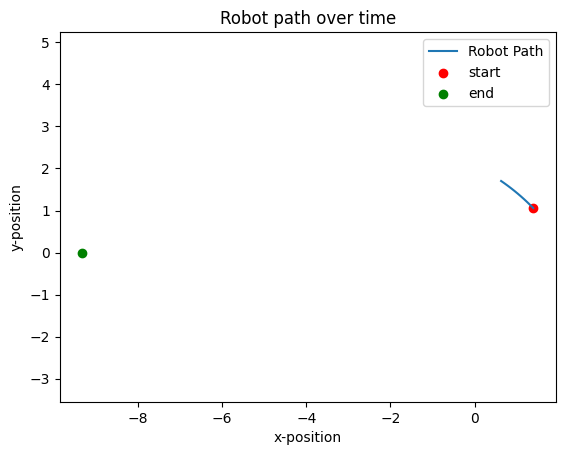

In [7]:
# Tell the simulator to its built-in kinematic model
env.unwrapped.motion_model = gym_neu_racing.motion_models.Unicycle()

# Run the simulation and plot the path taken
num_steps = 10
observation_history = simulate_n_steps(env, num_steps, dummy_unicycle_controller)
plot_path(env, observation_history)

## 1b) Implement a discrete-time unicycle kinematic model

In lecture, we gave the continuous time kinematic model for a unicycle in the form of an ODE (i.e., $\dot{x} = f(x, u)$). In this problem, you should use a simple first-order method (the Euler method) to solve this ODE at discrete timesteps from an initial state, $x[t+dt] = g(x[t], u[t], dt)$.

You should also make sure that your `step` function clips the action so as to respect the control limits. As a hint, you can use `np.clip` and access the control limits with `self.action_space.low` and `self.action_space.high`.

**Deliverables**:
- Implement the `step` method of the `Unicycle` class below
- Generate a plot of the path using your `plot_path` function from above

In [8]:
from gym_neu_racing.motion_models.motion_model import MotionModel


class Unicycle(MotionModel):
    def __init__(self, v_min=0, v_max=1, w_min=-2*np.pi, w_max=2*np.pi):
        self.action_space = spaces.Box(np.array([v_min, w_min]),
                                       np.array([v_max, w_max]),
                                       shape=(2,),
                                       dtype=float)
        super().__init__()

    def step(self, current_state: np.ndarray, action: np.ndarray, dt: float = 0.1) -> np.ndarray:

        # Ensure the action respects the control limits of the unicycle model
        action_clip = np.clip(action, self.action_space.low, self.action_space.high)

        # Extract current state variables
        x, y, theta = current_state  # Current position and orientation
        v, w = action_clip           # Linear and angular velocities after clipping

        # Update x-coordinate using the unicycle kinematic model
        x_next = x + v * np.cos(theta) * dt

        # Update y-coordinate using the unicycle kinematic model
        y_next = y + v * np.sin(theta) * dt

        # Update orientation (theta) using angular velocity
        theta_next = theta + w * dt

        # Combine the updated state variables into a single array
        next_state = np.array([x_next, y_next, theta_next])

        # Return the computed next state
        return next_state


You can tell the simulator (`env`) to use your kinematic model by setting `env.motion_model = YourMotionModel()` (a small caveat is that we have some [wrappers](https://gymnasium.farama.org/api/wrappers/) around the simulator, so you should use the `unwrapped` attribute to directly modify attributes of the base simulator). The simulator will call your motion model's `step` method each timestep (i.e., `self.motion_model.step(self.state.copy(), action)`). To test your kinematic model, you can use the same general idea as before:

initial state: [-0.64657984  1.19547933 -2.39363402]
current state: [-0.71988772  1.12746496 -2.37363402]
current state: [-0.79182075  1.05799814 -2.35363402]
current state: [-0.86235014  0.98710664 -2.33363402]
current state: [-0.93144769  0.91481882 -2.31363402]
current state: [-0.99908577  0.8411636  -2.29363402]
current state: [-1.06523731  0.76617045 -2.27363402]
current state: [-1.12987585  0.68986934 -2.25363402]
current state: [-1.19297555  0.61229082 -2.23363402]
current state: [-1.25451117  0.5334659  -2.21363402]
current state: [-1.31445808  0.45342611 -2.19363402]


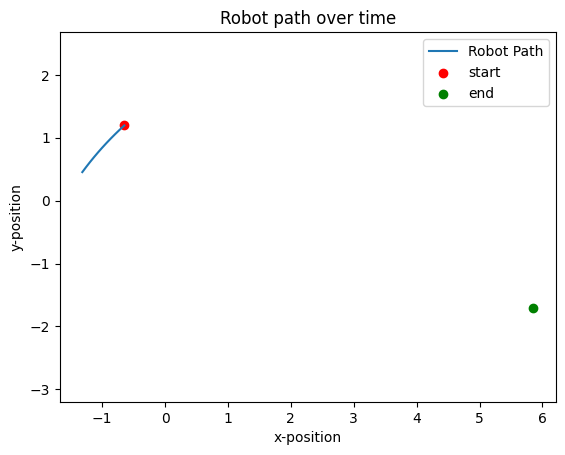

In [9]:
# Tell the simulator to use your kinematic model from above
env.unwrapped.motion_model = Unicycle()

# Run the simulation (using the dummy_unicycle controller) and plot the path taken
num_steps = 10
observation_history = simulate_n_steps(env, num_steps, dummy_unicycle_controller)
plot_path(env, observation_history)

## 1c) Implement a discrete-time Simple Car kinematic model

[Section 13.1.2 of Lavelle's book](https://lavalle.pl/planning/ch13.pdf) provides a good explanation of the Simple Car kinematics. In this part, you should implement a first-order discrete time approximation of this model.

**Deliverables**:
- Implement the `SimpleCar` class below

In [10]:
class SimpleCar(MotionModel):
    def __init__(self, L=1., v_min=-1, v_max=1, phi_min=-np.pi/4, phi_max=np.pi/4):
        self.action_space = spaces.Box(np.array([v_min, phi_min]),
                                 np.array([v_max, phi_max]),
                                 shape=(2,),
                                 dtype=float)
        self.L = L
        super().__init__()

    def step(self, current_state: np.ndarray, action: np.ndarray, dt: float = 0.1) -> np.ndarray:

      # Ensure the action respects the control limits of the bicycle model
      action_clip = np.clip(action, self.action_space.low, self.action_space.high)

      # Extract current state variables
      x, y, theta = current_state  # Current position and orientation
      u_s, u_phi = action_clip     # Speed and steering angle after clipping

      # Update x-coordinate using the bicycle kinematic model
      x_next = x + u_s * np.cos(theta) * dt

      # Update y-coordinate using the bicycle kinematic model
      y_next = y + u_s * np.sin(theta) * dt

      # Update orientation (theta) using the steering angle and speed
      theta_next = theta + (u_s / self.L) * np.tan(u_phi) * dt

      # Combine the updated state variables into a single array
      next_state = np.array([x_next, y_next, theta_next])

      # Return the computed next state
      return next_state

In [11]:
def dummy_car_controller(current_state: np.ndarray) -> np.ndarray:
  return np.array([0.5, -0.1]) # [linear speed, steering angle]

initial state: [-1.0824647  -0.11067542 -0.93462065]
current state: [-1.05275852 -0.1508941  -0.94465412]
current state: [-1.02345736 -0.19140882 -0.95468758]
current state: [-0.99456417 -0.23221548 -0.96472105]
current state: [-0.96608186 -0.27330998 -0.97475452]
current state: [-0.9380133  -0.31468819 -0.98478799]
current state: [-0.91036131 -0.35634593 -0.99482145]
current state: [-0.88312868 -0.39827902 -1.00485492]
current state: [-0.85631815 -0.44048323 -1.01488839]
current state: [-0.82993241 -0.48295431 -1.02492185]
current state: [-0.80397413 -0.52568799 -1.03495532]


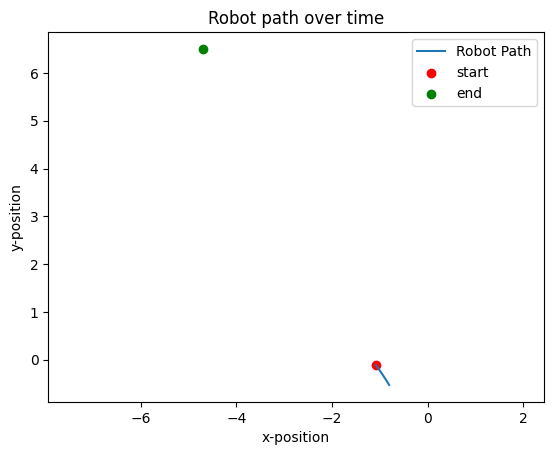

In [12]:
# Tell the simulator to use your kinematic model from above
env.unwrapped.motion_model = SimpleCar(L=0.5)

# Run the simulation (using the dummy car controller) and plot the path taken
num_steps = 10
observation_history = simulate_n_steps(env, num_steps, dummy_car_controller)
plot_path(env, observation_history)

# Problem 2: Controlling the Robot to Reach a Goal Coordinate

## 2a) Open-Loop Control

Using the `Unicycle` model you implemented above, you will now command the system to reach a goal position. Start with open-loop control, i.e., measure the intial state (returned by `env.reset`) and then calculate a sequence of actions to apply.

After that sequence is computed, run the simulator forward for several steps, and at each step, simply grab the corresponding control value from that pre-computed sequence. You can use this example `open_loop_control_policy` implementation as a first try.

Your job is to implement a smarter `open_loop_control_policy` that gets the system to reach (close) to the goal.

Remember: you are only provided with the initial state, goal position, and the maximum number of steps allowed -- you can't access the system's state once it has started moving! That would be closed-loop control, which we'll implement next :)

**Deliverables**:
- Implement the `open_loop_control_policy`, which should produce a sequence of control commands that will lead to the goal. This can be a very simple hard-coded policy (e.g., always send the same v, w)
- Generate 1 plot that shows your open-loop controller drives the noise-free system to the goal (it only has to work for 1 test case). Include the path taken and the start/goal coordinates in your plot.
- Generate 1 plot that shows your open-loop controller running on the noisy system (it's ok if it doesn't work on this system). Include the path taken and the start/goal coordinates in your plot.

In [13]:
def open_loop_control_policy(init_state: np.ndarray, goal: np.ndarray, num_steps: int = 10) -> list[np.ndarray]:

    # Calculate the time step based on the number of steps
    dt = 1 / num_steps  # Time step per control command

    # Extract initial state values
    x_initial, y_initial, theta_initial = init_state  # Initial position and orientation of the robot
    x_goal, y_goal = goal  # Goal position

    # Compute the difference in x and y between goal and initial position
    dx = x_goal - x_initial  # Difference in x-coordinate
    dy = y_goal - y_initial  # Difference in y-coordinate

    # Compute the Euclidean distance from the initial state to the goal
    distance = np.sqrt(dx**2 + dy**2)  # Distance between initial and goal position

    # Compute the desired orientation (theta) to point towards the goal
    des_theta = np.arctan2(dy, dx)  # Desired angle to the goal (in radians)

    # Compute linear velocity (v) to drive towards the goal
    # The velocity is proportional to the distance and inversely proportional to the time step
    velocity = min(1.0, distance / (num_steps * dt))  # Max velocity is capped at 1.0

    # Compute angular velocity (w) to align the robot's orientation with the desired heading
    ang_velocity = min(0.48, (des_theta - theta_initial) / (num_steps * dt))  # Max angular velocity is capped at 0.48 rad/s

    # Create a control sequence where each element is the control input [velocity, angular_velocity]
    # In open-loop control, we assume the control inputs are constant for each step
    control_sequence = [np.array([velocity, ang_velocity]) for _ in range(num_steps)]

    # Return the computed control sequence
    return control_sequence


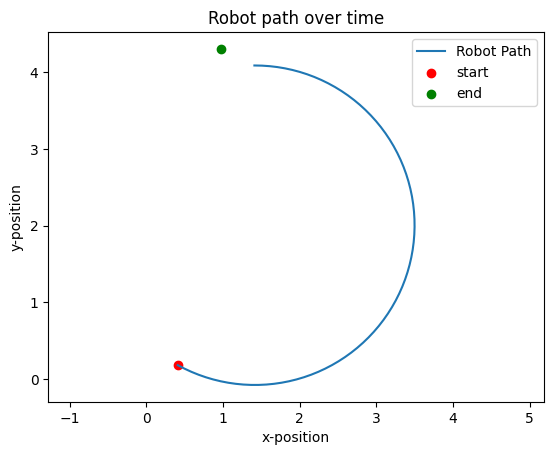

Success! Your open-loop controller drove the system to the goal.


In [14]:
np.random.seed(0)
max_num_steps = 200

env.unwrapped.motion_model = Unicycle()
obs, _ = env.reset() # initial observation of the system's state vector
observation_history = [obs]

# query your open loop controller based on the initial state of the system
control_sequence = open_loop_control_policy(obs, env.unwrapped.goal, num_steps=max_num_steps)

# Now that we've computed the control sequence, run the system forward until
# we reach max_num_steps or the system's state is close to the goal
for step in range(max_num_steps):
  action = control_sequence[step]
  obs, _, terminated, _, _ = env.step(action)
  observation_history.append(obs)
  if terminated:
    break

# Generate a simple plot of the path taken
plot_path(env, observation_history)

if terminated:
  print('Success! Your open-loop controller drove the system to the goal.')
else:
  print('Your open-loop controller did not successfully drive the system to the goal.')


Now, let's see what happens if we try that same `control_sequence` on a version of the environment where the wheels are a little bit slippery, so our simple unicycle model does not describe the true system perfectly.



In [15]:
class NoisyUnicycle(Unicycle):
  """Same as Unicycle but add process noise at each step."""
  def __init__(self,
               process_noise_limits=np.array([0.1, 0.1, 0.5]),
               v_min=0, v_max=1, w_min=-2*np.pi, w_max=2*np.pi):
    self.process_noise_limits = process_noise_limits
    super().__init__(v_min=v_min, v_max=v_max, w_min=w_min, w_max=w_max)

  def step(self, current_state, action, dt=0.1) -> np.ndarray:

    """Add process noise to the parent kinematics model."""
    next_state = super().step(current_state, action, dt=dt)
    perturbed_next_state = next_state + np.random.uniform(low=-self.process_noise_limits, high=self.process_noise_limits)

    return perturbed_next_state

This class we wrote for you will make it so you can't perfectly measure the system's state. It adds random noise to the `obs` that the `env` returns at each step:

In [16]:
from gymnasium import ObservationWrapper

class NoisyStateFeedbackWrapper(ObservationWrapper):
  def __init__(self, env, sensor_noise_limits=np.array([0.05, 0.05, 0.2])):
    self.sensor_noise_limits = sensor_noise_limits
    super().__init__(env)

  def observation(self, observation: dict) -> np.ndarray:
    obs = observation["state"] + np.random.uniform(low=-self.sensor_noise_limits, high=self.sensor_noise_limits)
    return obs

Now, run your open loop controller on a Unicycle with both process & sensor noise. Your open-loop control sequence probably does not drive the system to the goal anymore. This is to be expected! It's like trying to park a car in a parking spot with your eyes closed. We will implement a much smarter strategy next.

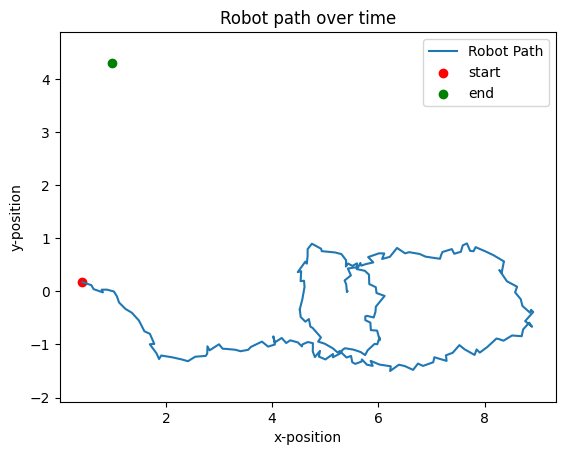

Your open-loop controller did not successfully drive the system to the goal.


In [17]:
np.random.seed(0)
max_num_steps = 200

env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")

# Add both sensor noise & process noise to make the problem more challenging
env = NoisyStateFeedbackWrapper(env)
env.unwrapped.motion_model = NoisyUnicycle()

obs, _ = env.reset() # initial observation of the system's state vector
observation_history = [obs]

# query your open loop controller based on the initial state of the system
control_sequence = open_loop_control_policy(obs, env.unwrapped.goal, num_steps=max_num_steps)

# Now that we've computed the control sequence, run the system forward until
# we reach max_num_steps or the system's state is close to the goal
for step in range(max_num_steps):
  action = control_sequence[step]
  obs, _, terminated, _, _ = env.step(action)
  observation_history.append(obs)
  if terminated:
    break

# Generate a simple plot of the path taken
plot_path(env, observation_history)

if terminated:
  print('Success! Your open-loop controller drove the system to the goal.')
else:
  print('Your open-loop controller did not successfully drive the system to the goal.')

## 2b) Closed-Loop Control: Pure Pursuit Algorithm

One of the most powerful ideas in robotic control is *feedback*. In this next part, we will implement a controller that measures the system's state at each step and uses that measurement to compute an action. This way, if the system ended up in a slightly different state than was expected from the simple model, the measurement will contain information about this discrepancy. Feedback control is often a great way to compensate for imperfect knowledge of the system you are working with.

Your job is to implement the `PurePursuitController` class with a `get_action` method that takes in the current `obs` and the `env.unwrapped.goal` coordinate (expressed in the global frame), and outputs one `action` = $[v, \omega]$. This `get_action` method will be called at each step, so there is no need to calculate a whole sequence of actions. The controller that you implement should be capable of driving the system to the goal.

In [91]:
from re import L
class PurePursuitController:
  def __init__(self, L=1.):
    """Store any hyperparameters here."""
    self.L = L

  def get_action(self, obs: np.ndarray, goal: np.ndarray) -> np.ndarray:

    # Unpack the current state and goal coordinates
    x, y, theta = obs  # Current state of the robot
    gx, gy = goal      # Goal position

    # Compute the distance from the robot to the goal
    dx = gx - x
    dy = gy - y
    distance = np.sqrt(dx**2 + dy**2)  # Euclidean distance to the goal



    # Compute the desired orientation (angle) towards the goal
    gtheta = np.arctan2(dy, dx)  # The angle of the line connecting the robot and the goal

    # Compute the heading error by normalizing the difference between the desired and current orientations
    theta_error = (gtheta - theta + np.pi) % (2 * np.pi) - np.pi  # Normalize between -pi and pi

    # Compute the perpendicular distance from the robot's current path to the goal
    perpendicular = distance * np.sin(theta_error)  # This is how much the robot needs to correct

    # Choose a constant linear speed for forward movement
    linear_speed = 1  # You can adjust this as necessary for the robot's performance

    # Compute the angular speed required to turn the robot towards the goal
    angular_speed = (linear_speed * 2 * abs(perpendicular)) / self.L**2  # The formula for angular speed

    # If the heading error is negative, reverse the angular speed direction
    if theta_error < 0:
        angular_speed = -angular_speed

    # Return the computed action: [linear_speed, angular_speed]
    return np.array([linear_speed, angular_speed])

This `validation` function may come in handy for debugging/testing your controller in some random scenarios

In [92]:
def validation(controller, motion_model=Unicycle, sensor_model=StateFeedbackWrapper, plot=False, num_runs=100, max_num_steps_per_run=200):
  success_per_run = np.empty((num_runs,), dtype=bool)
  num_steps_per_run = np.empty((num_runs,))
  for i in range(num_runs):
    np.random.seed(i)
    env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")

    env = sensor_model(env)
    env.unwrapped.motion_model = motion_model()

    obs, _ = env.reset()
    observation_history = [obs]
    for step in range(max_num_steps_per_run):
      action = controller.get_action(obs, env.unwrapped.goal)
      obs, _, terminated, _, _ = env.step(action)
      observation_history.append(obs)
      if terminated:
        break

    success_per_run[i] = terminated
    num_steps_per_run[i] = step
    if plot: plot_path(env, observation_history)

  avg_success = np.mean(success_per_run)
  avg_steps = np.mean(num_steps_per_run)
  return avg_success, avg_steps

For example, you can run your controller on 3 random cases and plot the resulting paths:

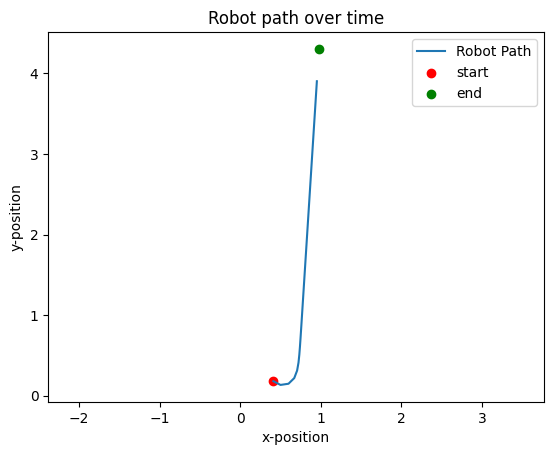

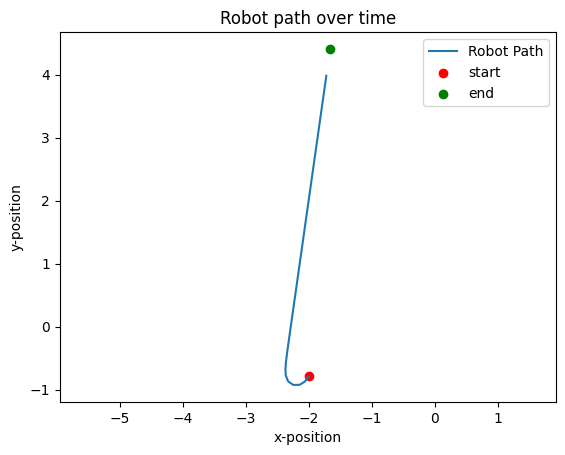

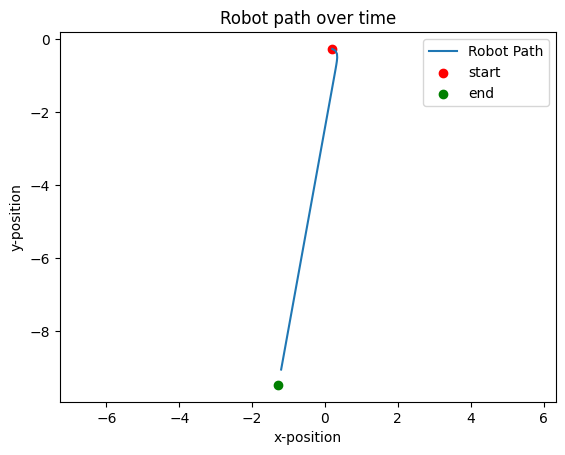

(1.0, 60.0)

In [93]:
pure_pursuit_controller = PurePursuitController(L=3.)
validation(controller=pure_pursuit_controller, num_runs=3, plot=True)

Once you're happy with your controller, you can run it against a larger validation test suite. This function will return the success rate (between 0 and 1) and average number of steps it takes your system to reach the goal.

In [94]:
pure_pursuit_controller = PurePursuitController()
avg_success, avg_steps = validation(controller=pure_pursuit_controller)
print("Success rate:", avg_success)
print("Avg. Number of Steps:", avg_steps)

Success rate: 1.0
Avg. Number of Steps: 79.44


Now we have a closed-loop controller that will drive the system to the goal.

Let's see if that controller can handle the noisy version of the Unicycle model:

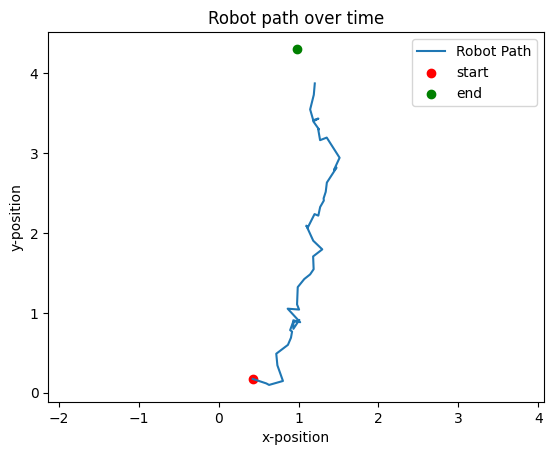

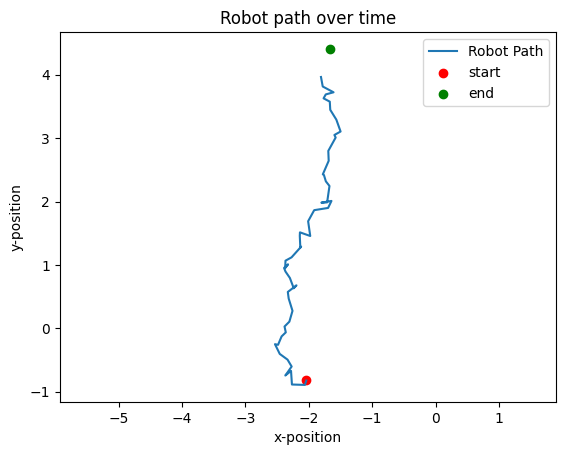

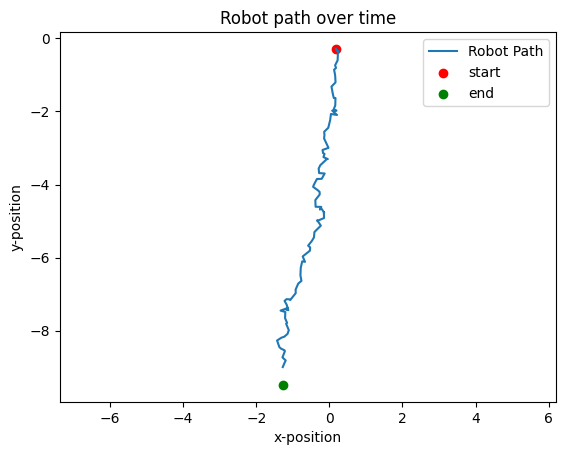

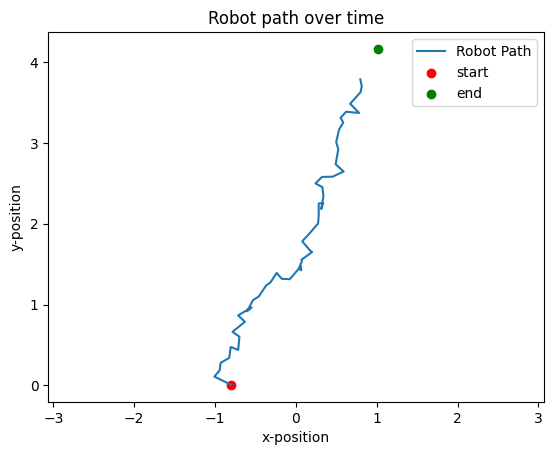

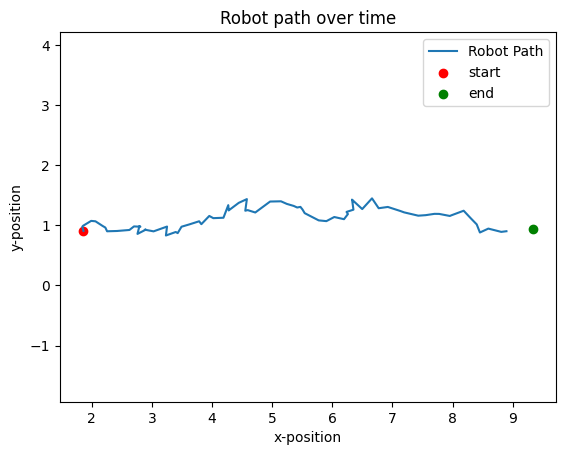

Success rate: 1.0
Avg. Number of Steps: 62.0


In [78]:
pure_pursuit_controller = PurePursuitController()
avg_success, avg_steps = validation(controller=pure_pursuit_controller, motion_model=NoisyUnicycle, sensor_model=NoisyStateFeedbackWrapper, num_runs=5, plot=True)
print("Success rate:", avg_success)
print("Avg. Number of Steps:", avg_steps)

Hopefully the answer is yes! Even though the vehicle doesn't perfectly follow the curve that the pure pursuit algorithm had in mind, the feedback control strategy compensates for the imperfect knowledge of the dynamics and drives the system to the goal.

**Deliverables**:
- Implement the `PurePursuitController` class using the ideas presented in Lecture 2. For partial credit, get a success rate of 100%. For full credit, get a success rate of 100% with an average number of steps below 82
- Include plots and text (one paragraph maximum) below describing your observations about the impact of hyperparameters on your algorithm.

Note: The autograder will simply instantiate your controller by running `PurePursuitController()`, so make sure that any hyperparameters default to the values you would like (e.g., use keyword arguments with default values for your lookahead distance).

## 2c) Extra Credit: Make your algorithm even better

Prof. Everett's simple pure pursuit implementation used an average number of steps of 79.44 on the validation set. You can earn 1 extra credit point if you upload a second implementation to Gradescope achieves below 80 steps on average (while also achieving 100% success). You can earn additional extra credit for having the best implementation in the class according to the Gradescope leaderboard.

You can try different strategies than just pure pursuit. Whichever control strategy you end up using, please use the `BetterController` class below for this part, which has the same class/function signatures as before.

Note: there will be a test suite that is similar but not identical to the validation method above to ensure your algorithm doesn't overfit to specific cases.

In [23]:
class BetterController:
  def __init__(self, L=3.):
    """Store any hyperparameters here."""
    self.L = L

  def get_action(self, obs: np.ndarray, goal: np.ndarray) -> np.ndarray:

    """Your implementation goes here"""
    x, y, theta = obs
    gx, gy = goal

    dx = gx - x
    dy = gy - y

    gtheta = np.arctan2(dy, dx) - theta
    gtheta = np.arctan2(np.sin(gtheta), np.cos(gtheta))  # Normalize the angle

    linear_speed = 25
    angular_speed  = (linear_speed * 2 * np.sin(gtheta)) / self.L
    #raise NotImplementedError()

    return np.array([linear_speed, angular_speed])